# Time Series

## DSDT presentation 

Stock market forecasting with RNN models.

In [2]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae 


In [3]:
from tensorflow import keras




In [4]:
path = "TSLA-2.csv"



In [5]:
#zip_path = keras.utils.get_file(origin=path, fname="stock_price.csv")
#csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(path) #, index_col=0)



In [6]:
df.head()



,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-09,51.816002,52.590000,51.358002,51.584000,51.584000,16670500
1,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
2,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
3,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
4,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000


In [7]:
df.shape

(1567, 7)

In [8]:
df.Close.min(), df.Close.max()

(28.733999, 883.090027)

In [9]:
plt.figure(figsize=(15, 8));
#plt.subplot(1,2,1);
plt.plot(df.Open.values, color='red', label='open')
plt.plot(df.Close.values, color='green', label='close')
plt.plot(df.Low.values, color='blue', label='low')
plt.plot(df.High.values, color='black', label='high')
plt.title('Stock prices')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('tesla-stock-price.jpeg')



In [10]:
training_set = df.iloc[:1300, 1:2].values
test_set = df.iloc[1300:, 1:2].values

In [11]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
shift = 30
for i in range(shift, 1300):
    X_train.append(training_set_scaled[i-shift:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(740, 60, 1)

In [23]:
dataset_train = df.iloc[:1300, 1:2]
dataset_test = df.iloc[1300:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - shift:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(shift, len(inputs)):
    X_test.append(inputs[i-shift:i, 0])
    y_test.append(inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)

(267, 30, 1)


In [13]:
def eval_model(model_name, X_test, y_test):
    model = keras.models.load_model(model_name)
    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    print(f"Test MAE: {mae(sc.inverse_transform(np.array(y_test).reshape(-1,1)), predicted_stock_price):.2f}")
    return predicted_stock_price



## Baseline - Simple Neural Net

In [24]:
from tensorflow import keras
from tensorflow.keras import layers

model_name = "dense.keras"
inputs = keras.Input(shape=(X_train.shape[1], 1))
x = layers.Flatten()(inputs)
x = layers.Dense(50, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(model_name,
                                    save_best_only=True)
]
model.compile(optimizer="NAdam", loss="mse", metrics=["mae"])
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=callbacks, verbose=0)

predicted_stock_price = eval_model(model_name, X_test, y_test)

#model = keras.models.load_model("dense.keras")

#predicted_stock_price = model.predict(X_test)
#predicted_stock_price = sc.inverse_transform(predicted_stock_price)
#print(f"Test MAE: {mae(sc.inverse_transform(np.array(y_test).reshape(-1,1)), predicted_stock_price):.2f}")





Test MAE: 75.24


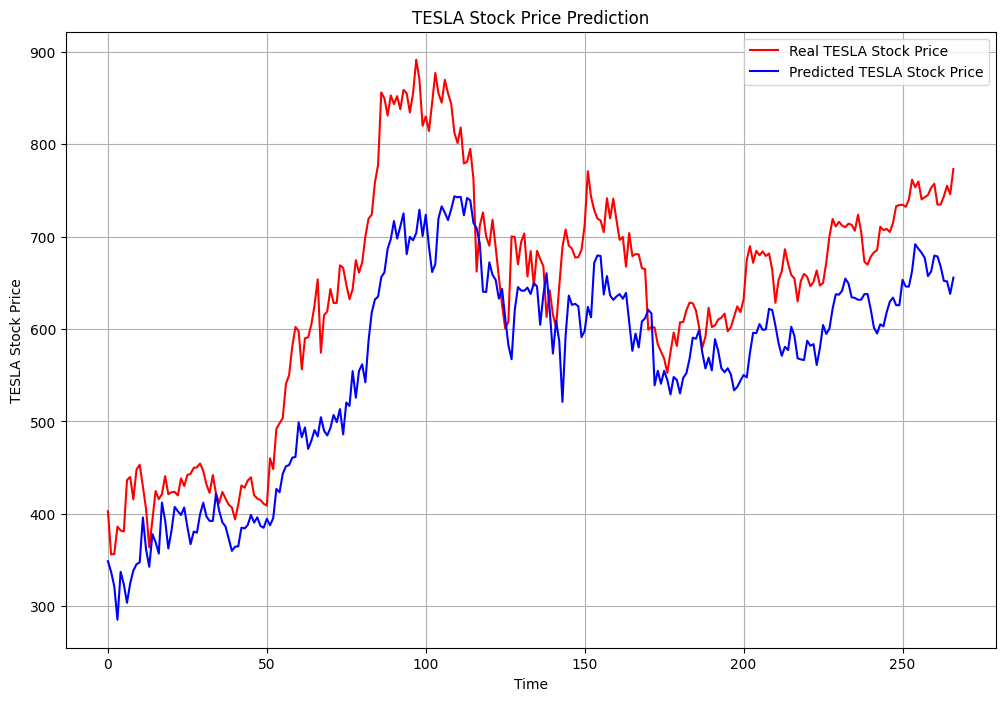

In [25]:
# Visualising the results
plt.figure(figsize=(12,8))
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
#plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.grid(True)
plt.show()



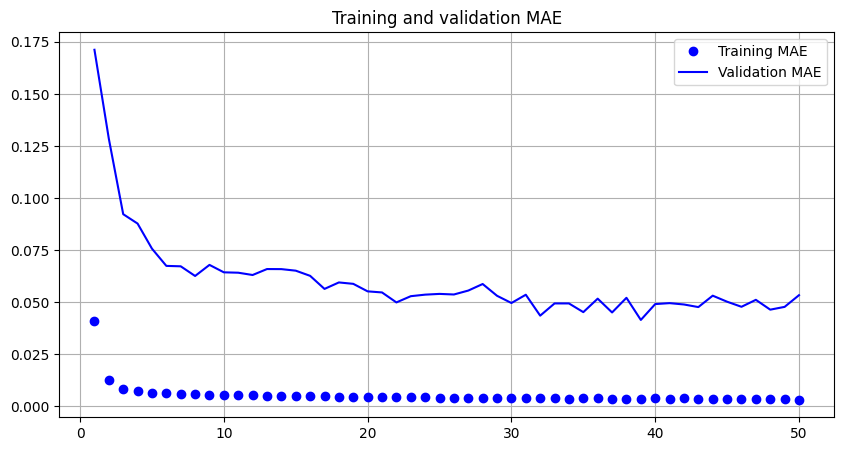

In [26]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,5))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.grid(True)
plt.legend()
plt.show()

## SimpleRNN

Test MAE: 76.46


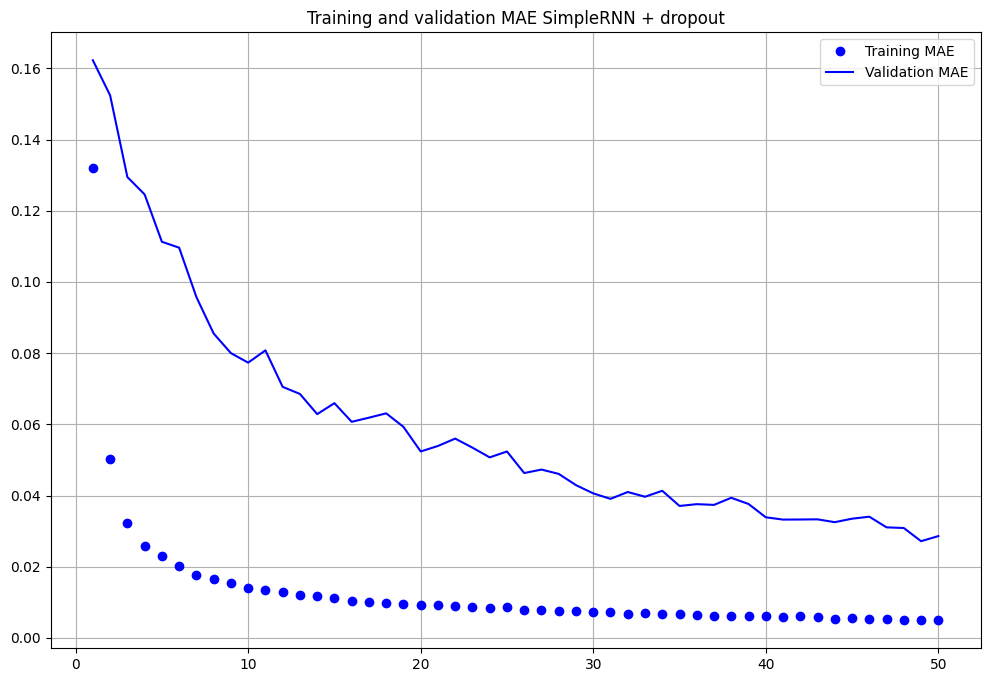

In [27]:
model_name = "rnn.keras"

inputs = keras.Input(shape=(X_train.shape[1],1))
x = layers.SimpleRNN(250, recurrent_dropout=0.2)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(model_name,
                                    save_best_only=True)
]
model.compile(optimizer="NAdam", loss="mse", metrics=["mae"])
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=callbacks, verbose = 0)

predicted_stock_price = eval_model(model_name, X_test, y_test)

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE SimpleRNN + dropout")
plt.grid(True)
plt.legend()
plt.show()




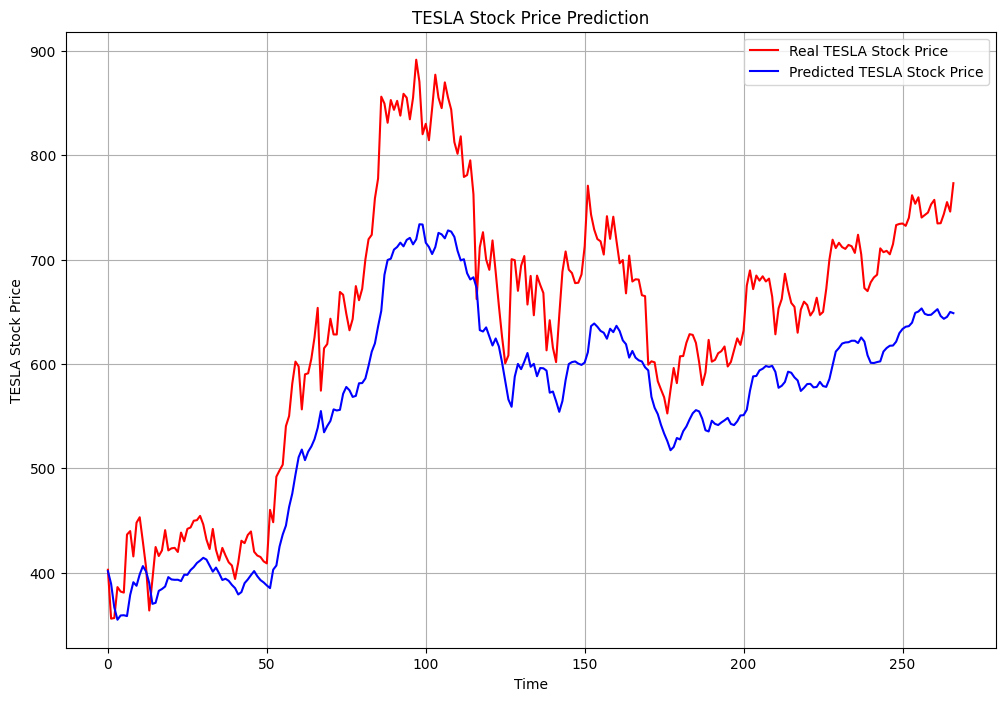

In [28]:
# Visualising the results
plt.figure(figsize=(12,8))
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
#plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.grid(True)
plt.show()




## LSTM

In [29]:
model_name = "lstm.keras"

inputs = keras.Input(shape=(X_train.shape[1],1))
x = layers.LSTM(200)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(model_name,
                                    save_best_only=True)
]
model.compile(optimizer="NAdam", loss="mse", metrics=["mae"])
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=callbacks, verbose = 0)

predicted_stock_price = eval_model(model_name, X_test, y_test)




Test MAE: 22.27


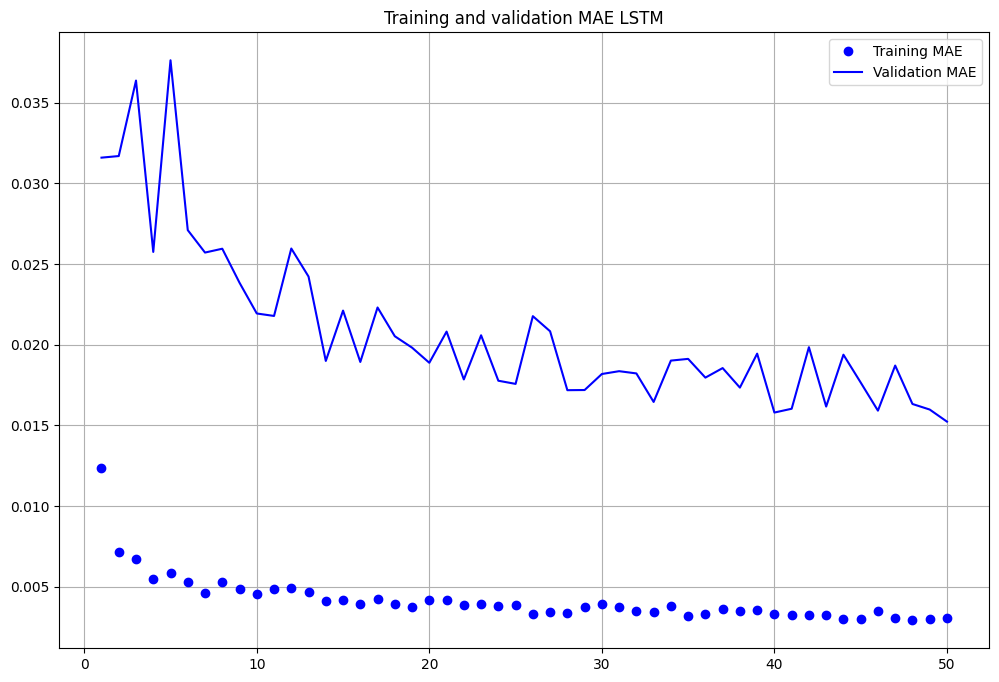

In [30]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE LSTM")
plt.legend()
plt.grid(True)
plt.show()

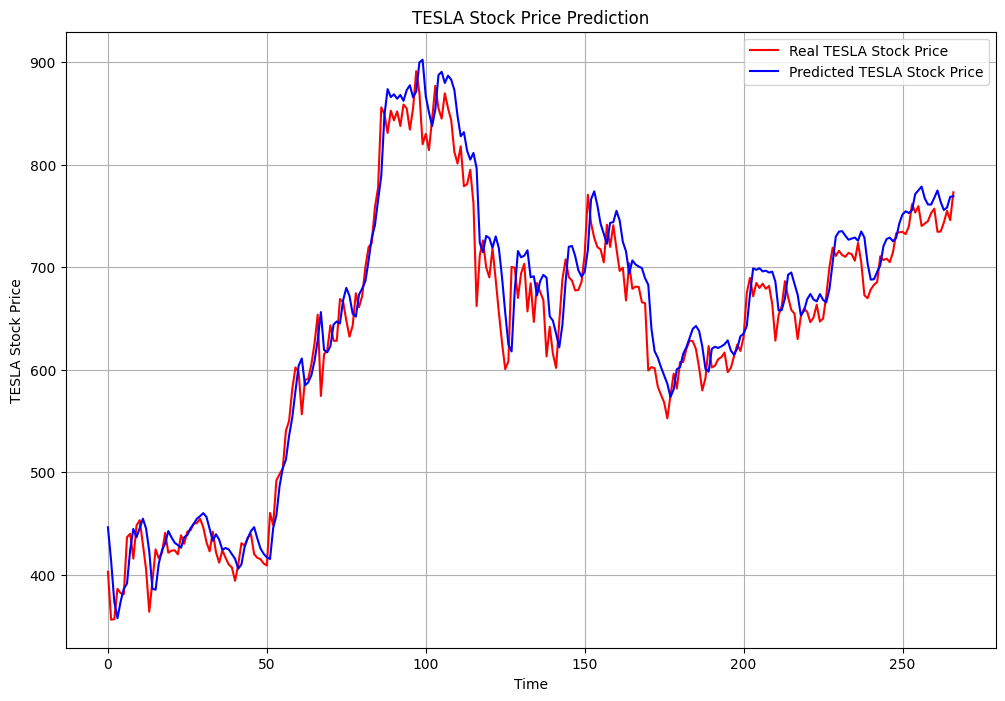

In [31]:
# Visualising the results
plt.figure(figsize=(12,8))
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
#plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.grid(True)
plt.show()



In [34]:
lstm_drop = "lstm_dropout.keras"
inputs = keras.Input(shape=(X_train.shape[1],1))
x = layers.LSTM(100, recurrent_dropout=0.25)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(lstm_drop,
                                    save_best_only=True)
]
model.compile(optimizer="NAdam", loss="mse", metrics=["mae"])
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=callbacks, verbose=0)

predicted_stock_price = eval_model(lstm_drop, X_test, y_test)



Test MAE: 27.57


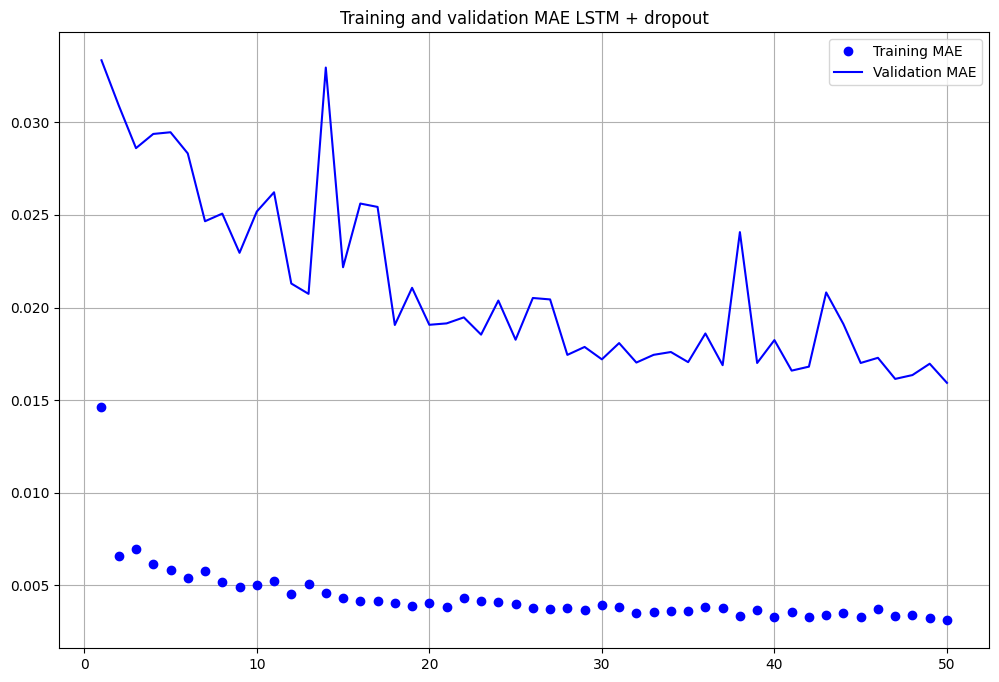

In [35]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE LSTM + dropout")
plt.grid(True)
plt.legend()
plt.show()

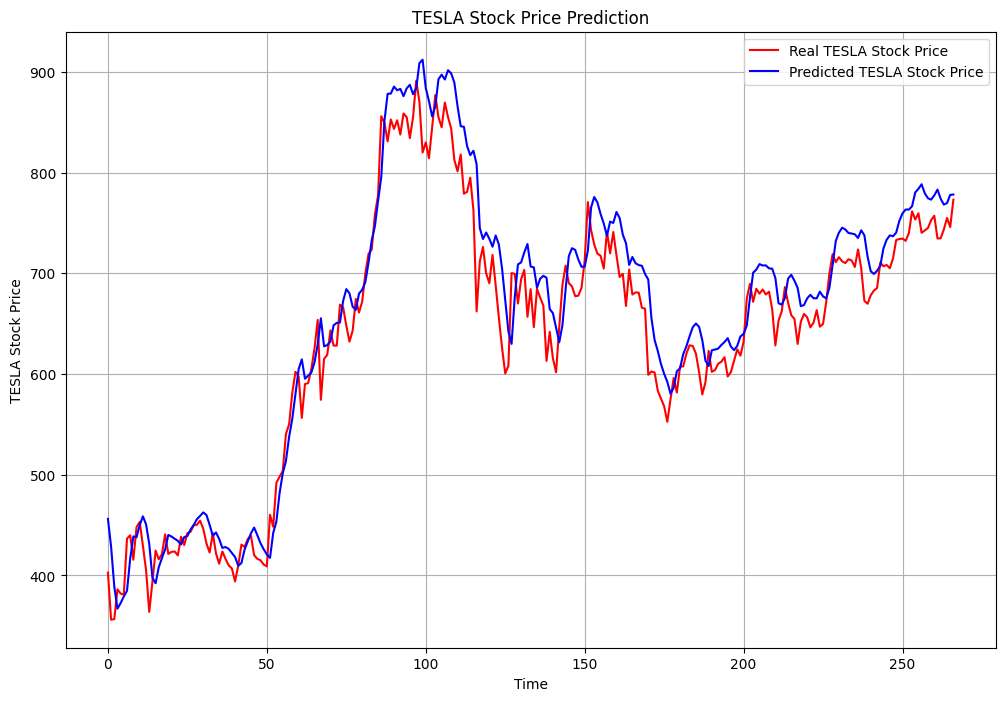

In [36]:
# Visualising the results
plt.figure(figsize=(12,8))
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
#plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.grid(True)
plt.show()

## GRU

Test MAE: 20.70


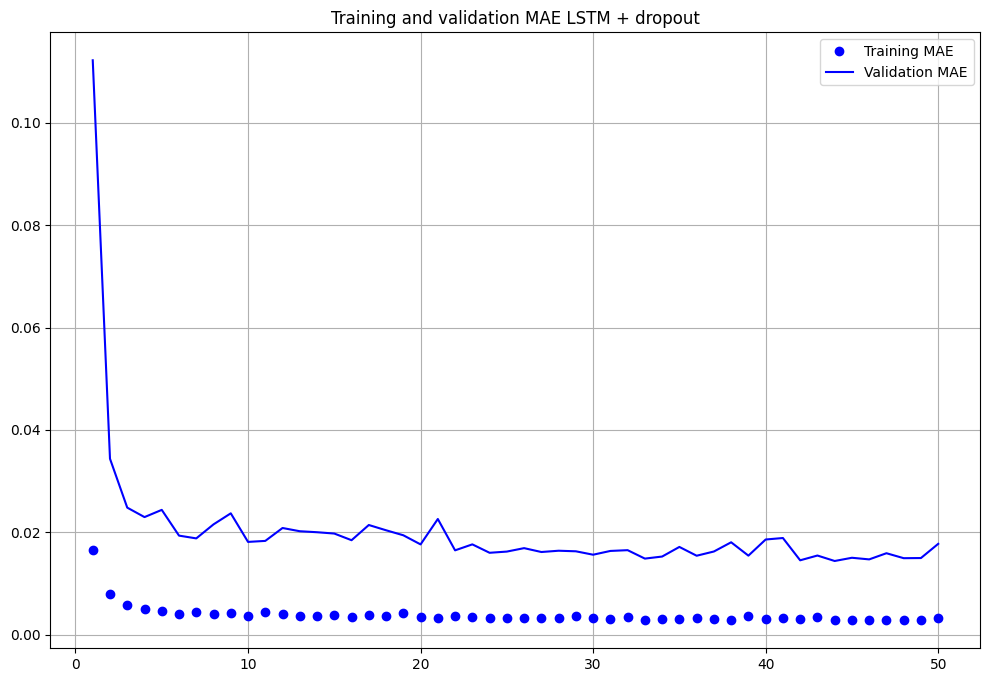

In [37]:
model_name = "gru.keras"

inputs = keras.Input(shape=(X_train.shape[1],1))
x = layers.GRU(50, recurrent_dropout=0.2)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(model_name,
                                    save_best_only=True)
]
model.compile(optimizer="NAdam", loss="mse", metrics=["mae"])
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=callbacks, verbose = 0)

predicted_stock_price = eval_model(model_name, X_test, y_test)

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE LSTM + dropout")
plt.grid(True)
plt.legend()
plt.show()



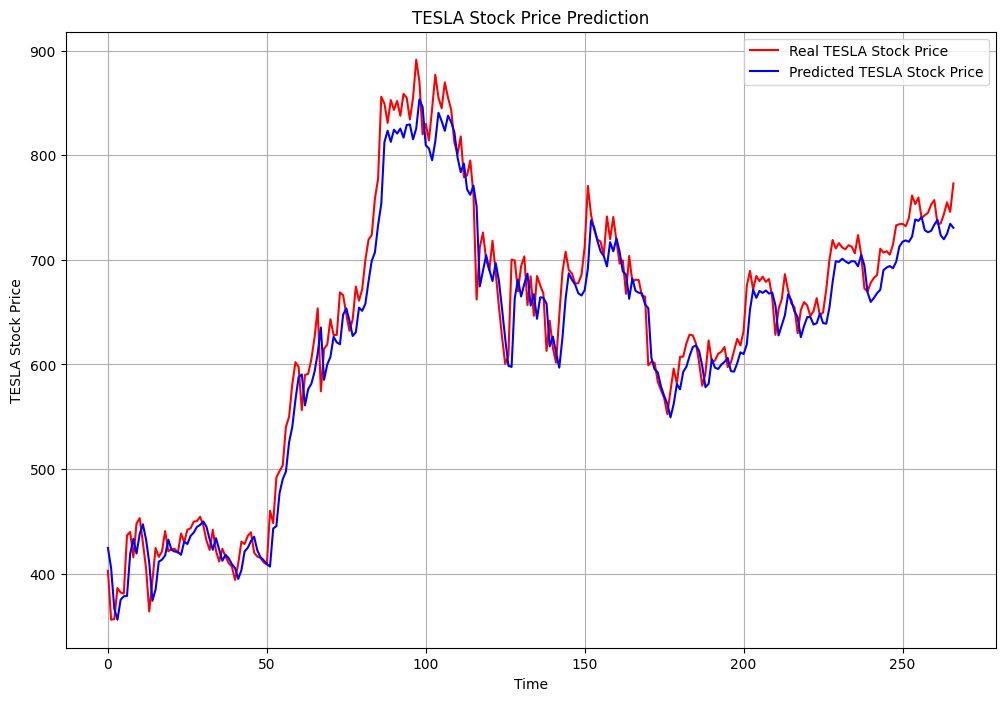

In [38]:
# Visualising the results
plt.figure(figsize=(12,8))
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
#plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.grid(True)
plt.show()




## Stacked SimpleRNN 

Test MAE: 448.94


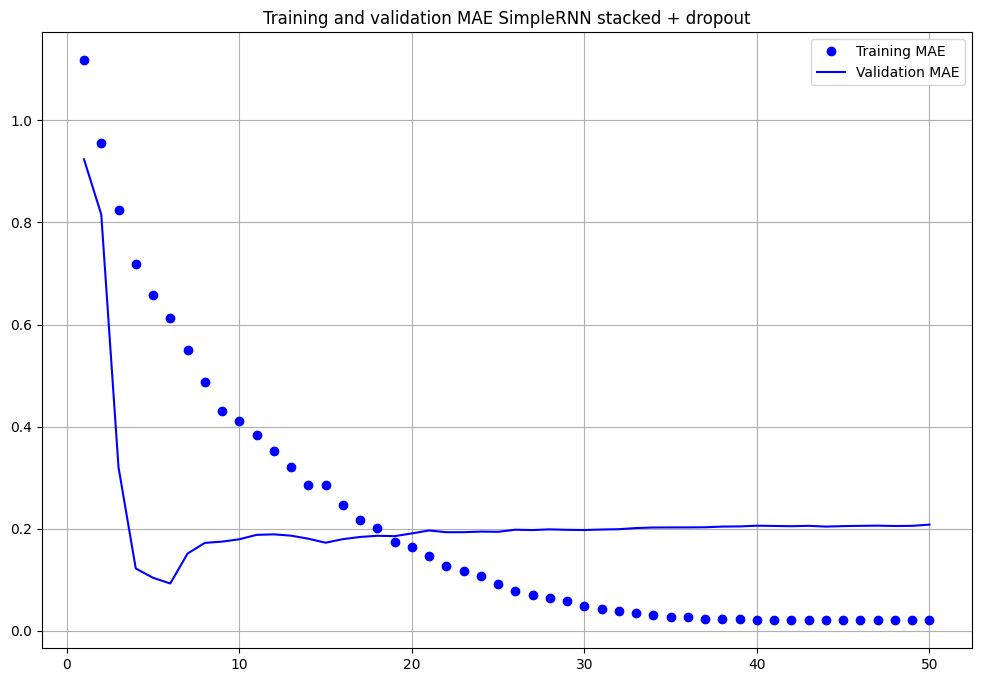

In [39]:
rnn_stacked_drop = "stacked_rnn_dropout.keras"
inputs = keras.Input(shape=(X_train.shape[1], 1))
x = layers.SimpleRNN(50, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.SimpleRNN(50, recurrent_dropout=0.5, return_sequences=True)(x)
x = layers.SimpleRNN(50, recurrent_dropout=0.5, return_sequences=True)(x)
x = layers.SimpleRNN(50, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(rnn_stacked_drop,
                                    save_best_only=True)
]
model.compile(optimizer="NAdam", loss="mse", metrics=["mae"])
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=callbacks, verbose=0)

predicted_stock_price = eval_model(rnn_stacked_drop, X_test, y_test)

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE SimpleRNN stacked + dropout")
plt.legend()
plt.grid(True)
plt.show()

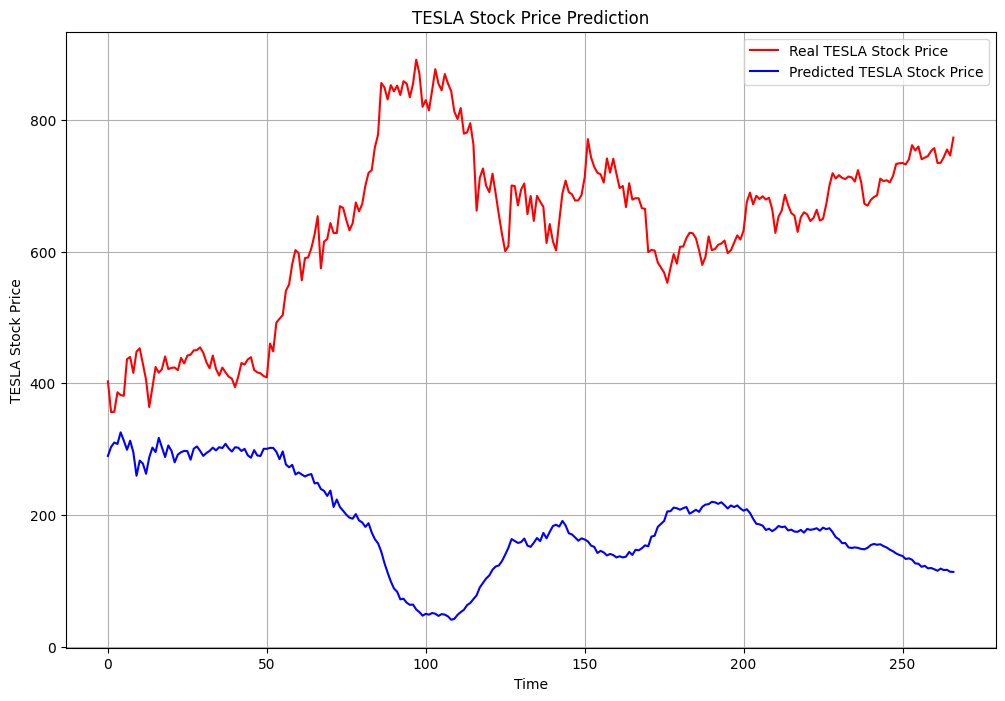

In [40]:
# Visualising the results
plt.figure(figsize=(12,8))
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
#plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.grid(True)
plt.show()

Test MAE: 146.99


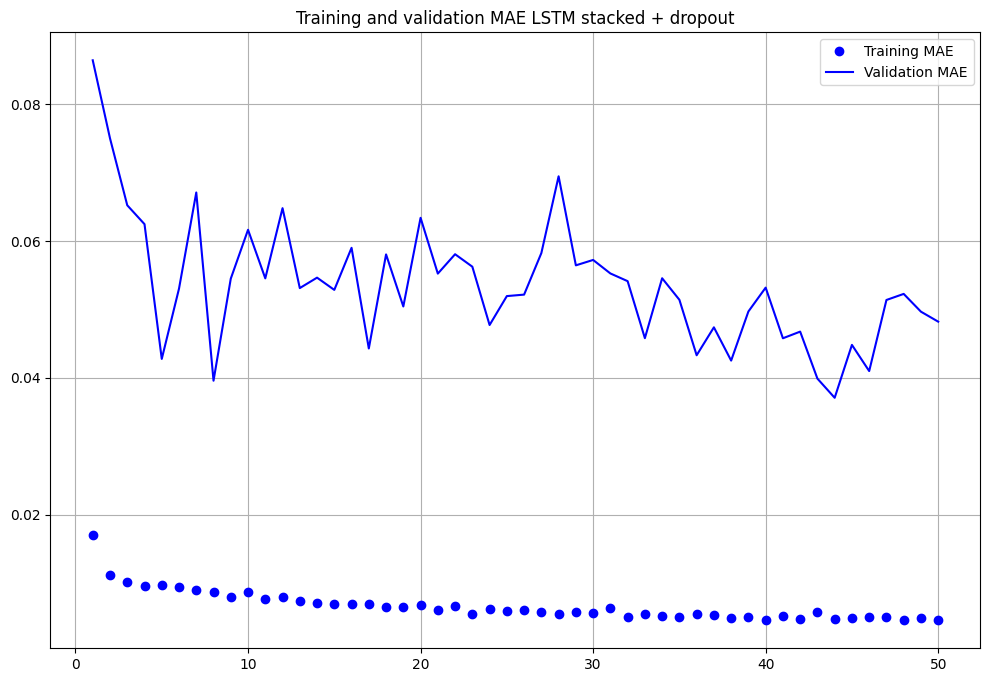

In [63]:
stacked_lstm_drop = "stacked_lstm_dropout.keras"
inputs = keras.Input(shape=(X_train.shape[1],1))
x = layers.LSTM(50, recurrent_dropout=0.25, return_sequences=True)(inputs)
x = layers.LSTM(50, recurrent_dropout=0.25, return_sequences=True)(x)
x = layers.LSTM(50, recurrent_dropout=0.25, return_sequences=True)(x)
x = layers.LSTM(50, recurrent_dropout=0.25)(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(stacked_lstm_drop,
                                    save_best_only=True)
]
model.compile(optimizer="NAdam", loss="mse", metrics=["mae"])
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=callbacks, verbose=0)

predicted_stock_price = eval_model(stacked_lstm_drop, X_test, y_test)

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE LSTM stacked + dropout")
plt.legend()
plt.grid(True)
plt.show()

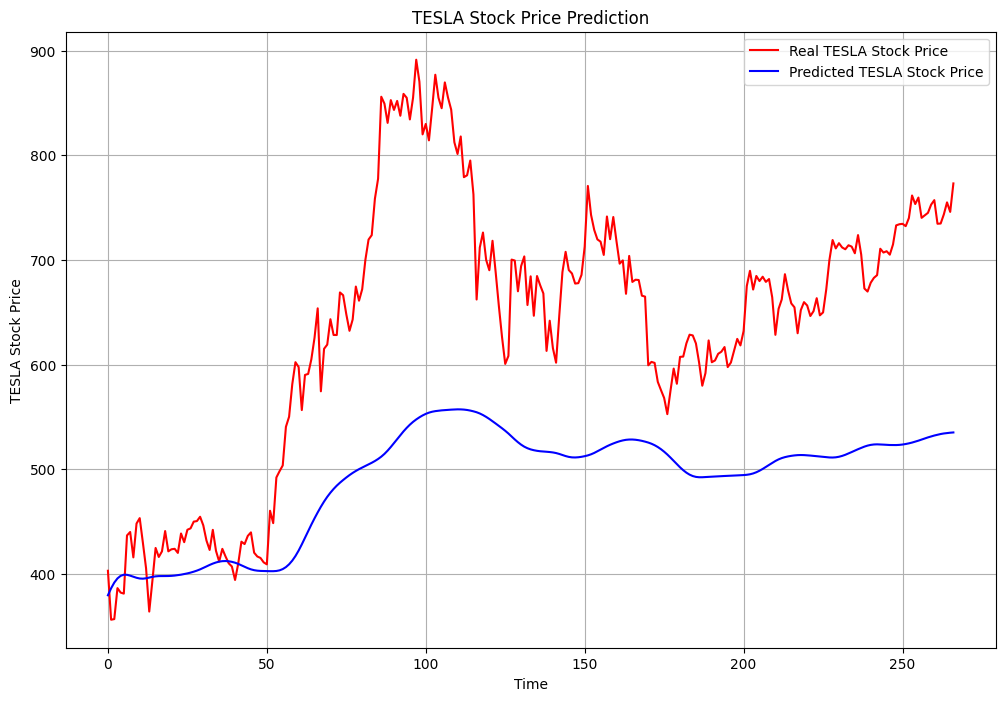

In [64]:
# Visualising the results
plt.figure(figsize=(12,8))
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
#plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.grid(True)
plt.show()

## Stacked GRU

In [43]:
stacked_gru_drop = "stacked_gru_drop.keras"
inputs = keras.Input(shape=(X_train.shape[1],1))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(x)
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(x)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(stacked_gru_drop,
                                    save_best_only=True)
]
model.compile(optimizer="NAdam", loss="mse", metrics=["mae"])
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=callbacks, verbose=0)

predicted_stock_price = eval_model(stacked_gru_drop, X_test, y_test)

Test MAE: 103.21


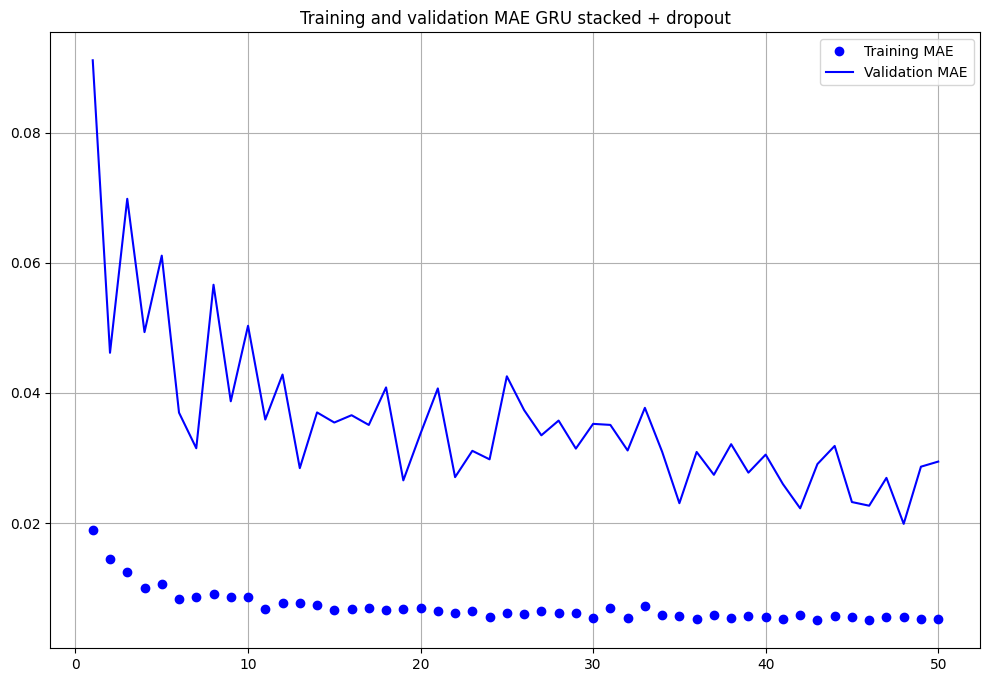

In [44]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE GRU stacked + dropout")
plt.legend()
plt.grid(True)
plt.show()

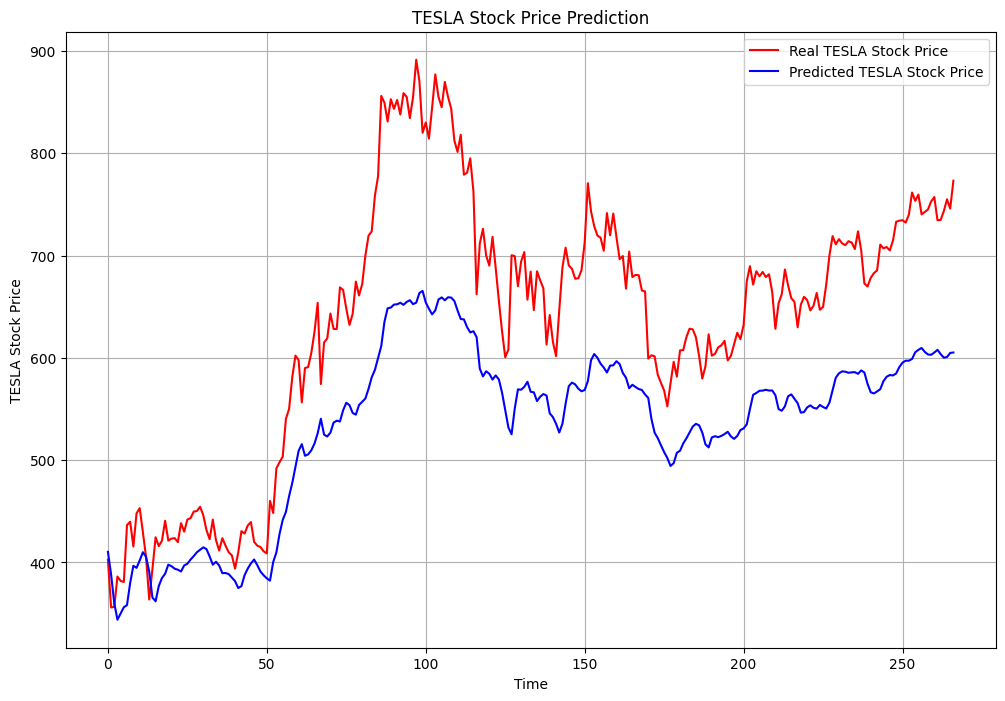

In [45]:
# Visualising the results
plt.figure(figsize=(12,8))
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
#plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.grid(True)
plt.show()

## Bidirectional SimpleRNN

In [69]:
bidirec_rnn = "bidirection_rnn.keras"


inputs = keras.Input(shape=(X_train.shape[1],1))
x = layers.Bidirectional(layers.SimpleRNN(300))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint(bidirec_rnn,
                                    save_best_only=True)
]


model.compile(optimizer="NAdam", loss="mse", metrics=["mae"])
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=callbacks, verbose=0)

predicted_stock_price = eval_model(bidirec_rnn, X_test, y_test)

Test MAE: 235.19


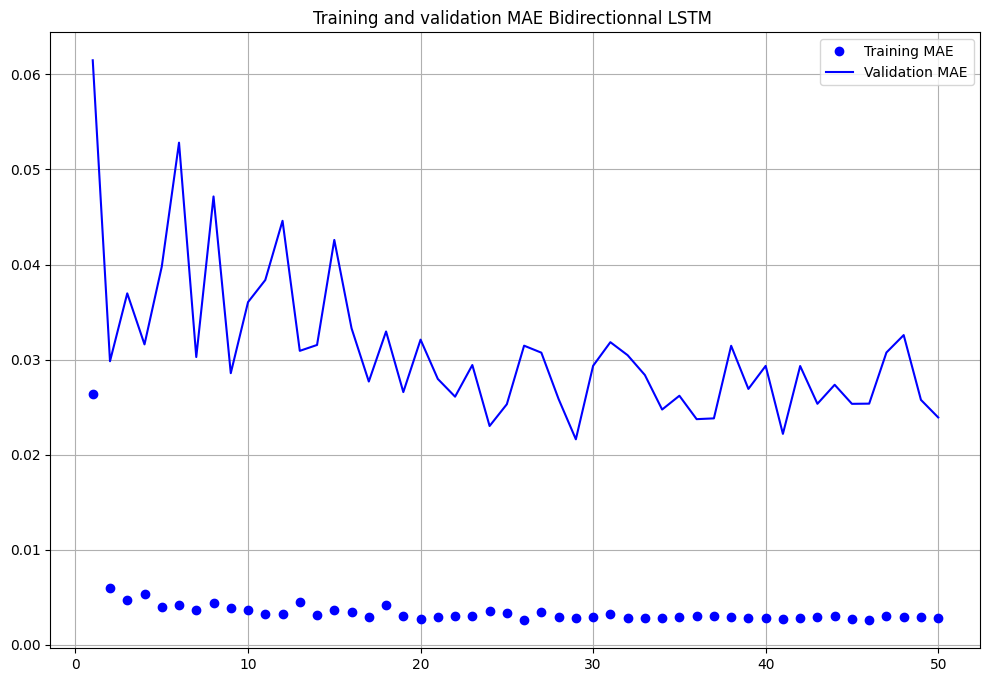

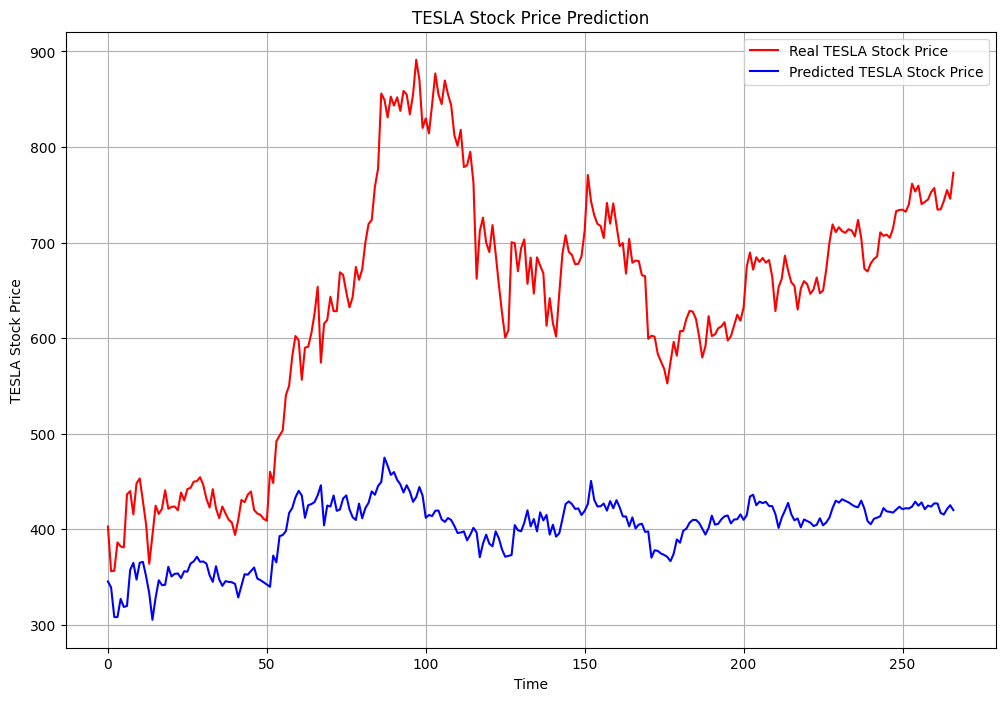

In [70]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE Bidirectionnal LSTM ")
plt.legend()
plt.grid(True)
plt.show()
# Visualising the results
plt.figure(figsize=(12,8))
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
#plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.grid(True)
plt.show()

## Bidirectional LSTM

In [47]:
bidirec_lstm = "bidirection_lstm.keras"


inputs = keras.Input(shape=(X_train.shape[1],1))
x = layers.Bidirectional(layers.LSTM(250))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint(bidirec_lstm,
                                    save_best_only=True)
]


model.compile(optimizer="NAdam", loss="mse", metrics=["mae"])
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=callbacks, verbose=0)

predicted_stock_price = eval_model(bidirec_lstm, X_test, y_test)

Test MAE: 19.20


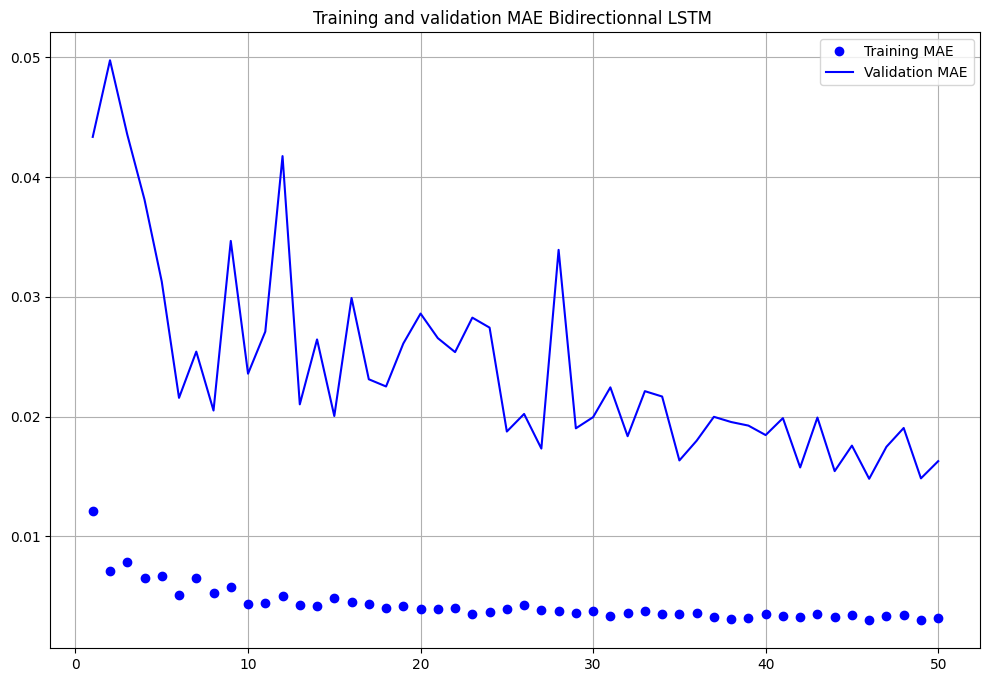

In [48]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE Bidirectionnal LSTM ")
plt.legend()
plt.grid(True)
plt.show()

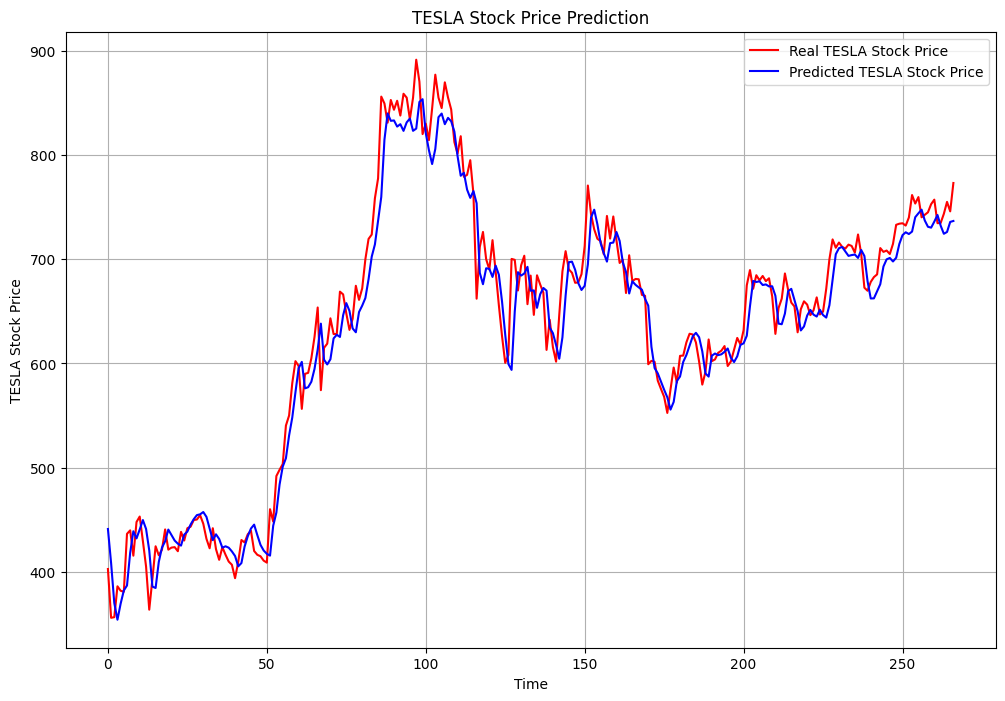

In [49]:
# Visualising the results
plt.figure(figsize=(12,8))
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
#plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.grid(True)
plt.show()

## Bidirectional GRU

In [50]:
bidirec_gru = "bidirection_gru.keras"


inputs = keras.Input(shape=(X_train.shape[1],1))
x = layers.Bidirectional(layers.GRU(250))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint(bidirec_gru,
                                    save_best_only=True)
]


model.compile(optimizer="NAdam", loss="mse", metrics=["mae"])
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=callbacks, verbose=0)

predicted_stock_price = eval_model(bidirec_gru, X_test, y_test)

Test MAE: 18.94


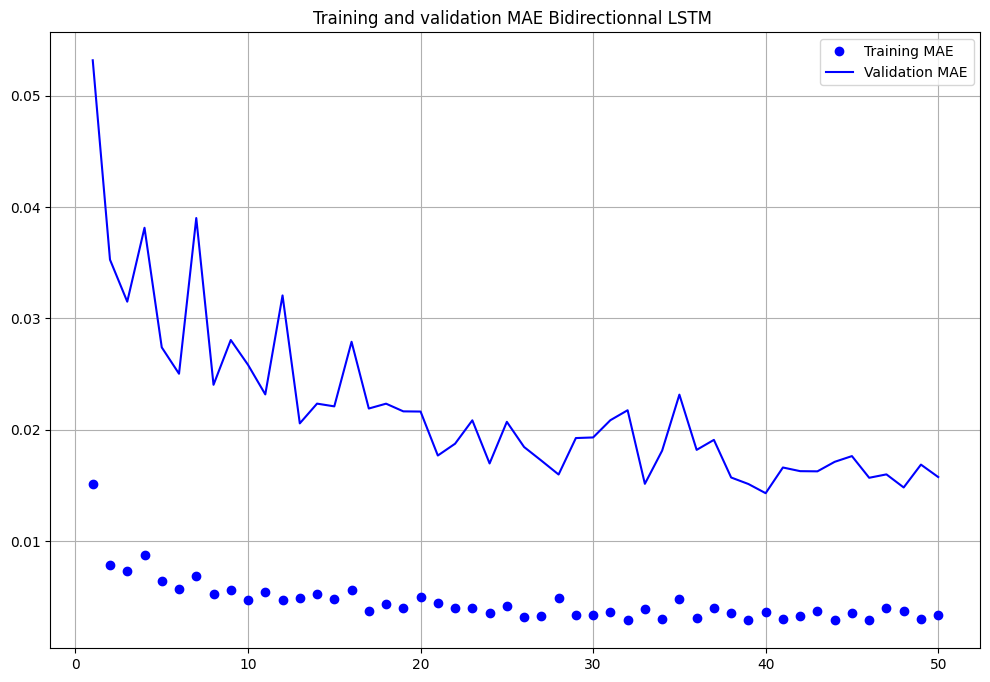

In [51]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE Bidirectionnal LSTM ")
plt.legend()
plt.grid(True)
plt.show()

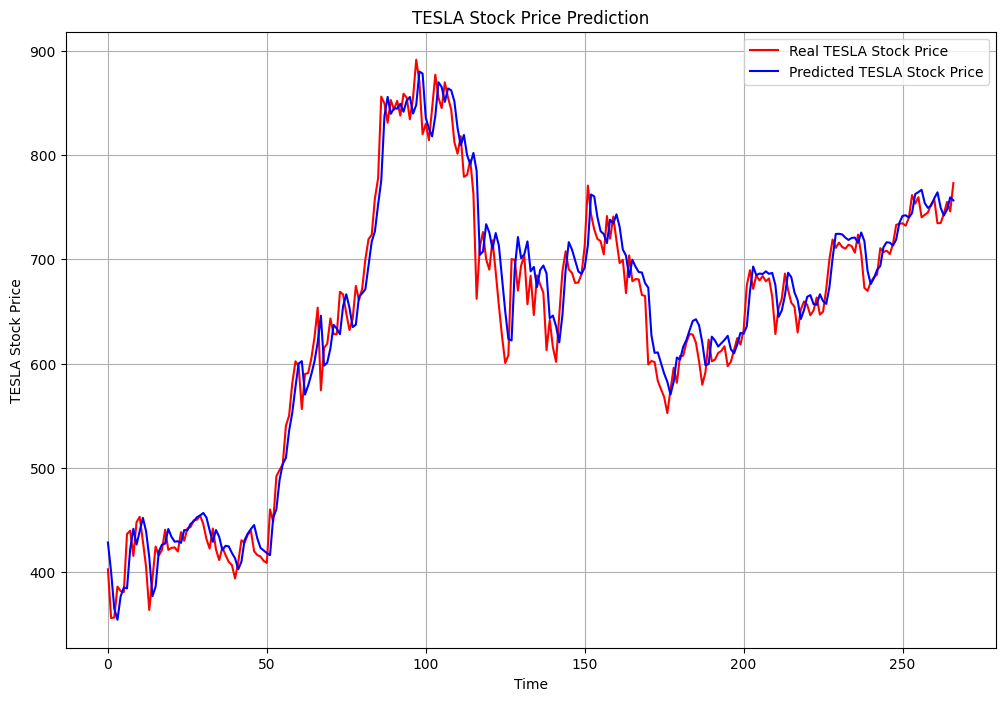

In [52]:
# Visualising the results
plt.figure(figsize=(12,8))
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
#plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.grid(True)
plt.show()

## Stacked bidirectional SimpleRNN

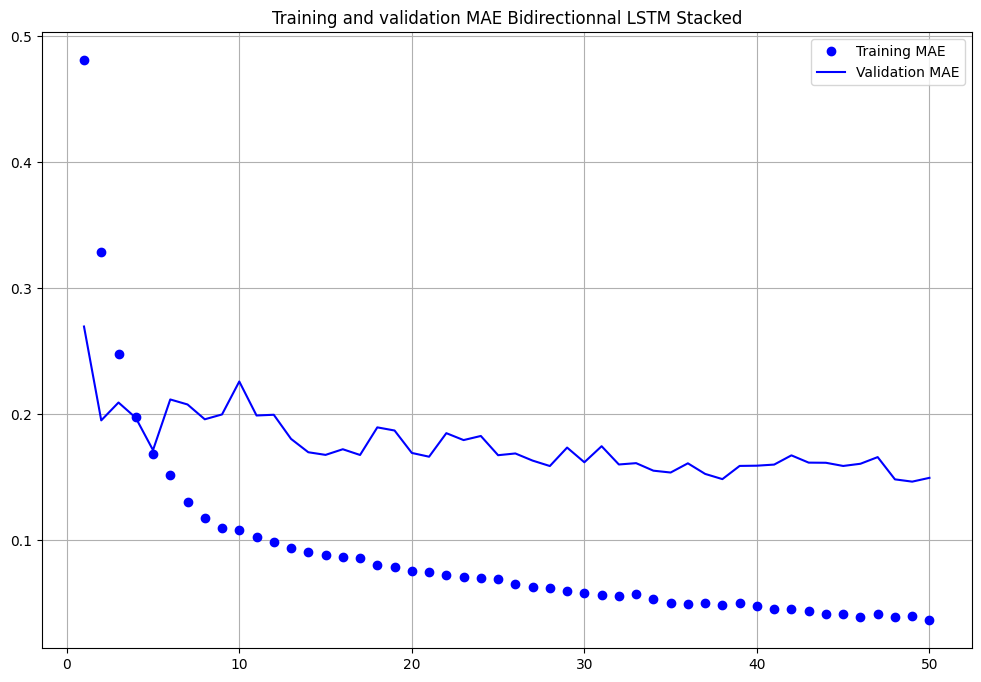

In [71]:
stacked_bidir = "stacked_bidir_rnn.keras"
inputs = keras.Input(shape=(X_train.shape[1],1))
x = layers.Bidirectional(layers.SimpleRNN(50, return_sequences=True, recurrent_dropout=0.25))(inputs)
x = layers.Bidirectional(layers.SimpleRNN(50, recurrent_dropout=0.25, return_sequences=True))(x)
x = layers.Bidirectional(layers.SimpleRNN(50, recurrent_dropout=0.25))(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(stacked_bidir,
                                    save_best_only=True)
]


model.compile(optimizer="NAdam", loss="mse", metrics=["mae"])
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=callbacks, verbose=0)


loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE Bidirectionnal LSTM Stacked")
plt.legend()
plt.grid(True)
plt.show()




Test MAE: 494.51


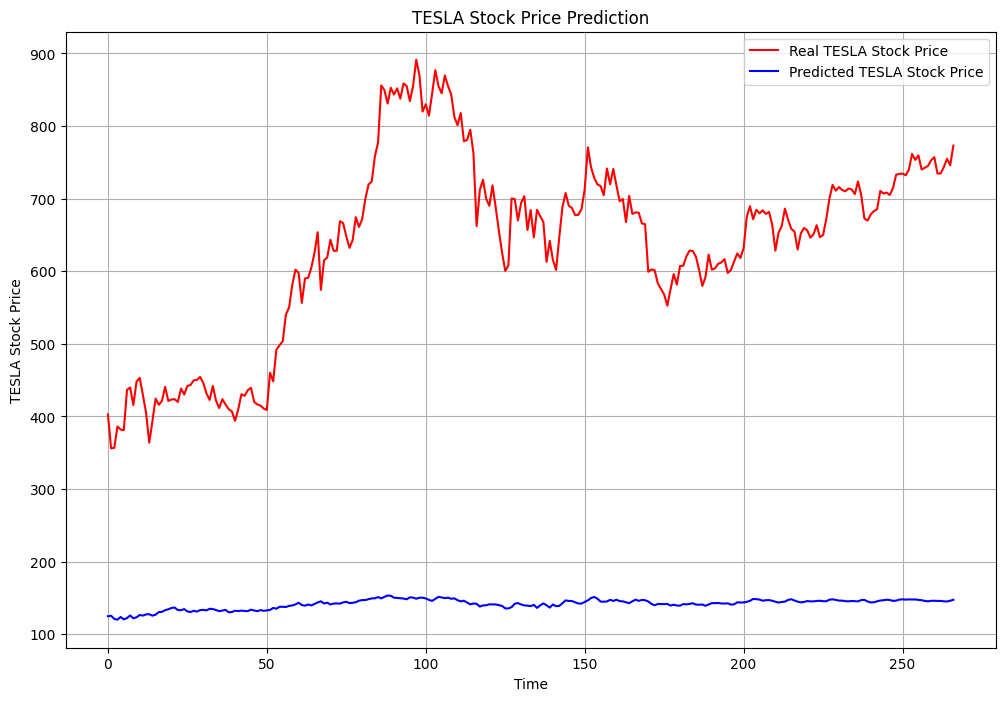

In [72]:
predicted_stock_price = eval_model(stacked_bidir, X_test, y_test)


# Visualising the results
plt.figure(figsize=(12,8))
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
#plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.grid(True)
plt.show()



## Stacked bidirectional LSTM

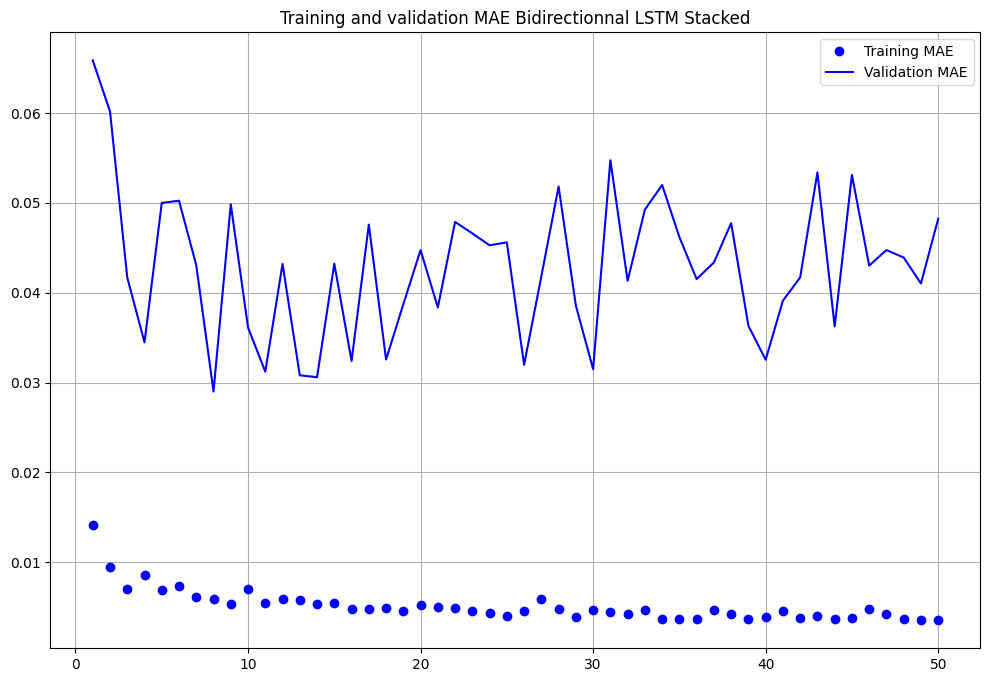

In [53]:
stacked_bidir = "stacked_bidir_lstm.keras"
inputs = keras.Input(shape=(X_train.shape[1],1))
x = layers.Bidirectional(layers.LSTM(50, return_sequences=True, recurrent_dropout=0.25))(inputs)
x = layers.Bidirectional(layers.LSTM(50, recurrent_dropout=0.25, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(50, recurrent_dropout=0.25))(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(stacked_bidir,
                                    save_best_only=True)
]


model.compile(optimizer="NAdam", loss="mse", metrics=["mae"])
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=callbacks, verbose=0)


loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE Bidirectionnal LSTM Stacked")
plt.legend()
plt.grid(True)
plt.show()



Test MAE: 124.32


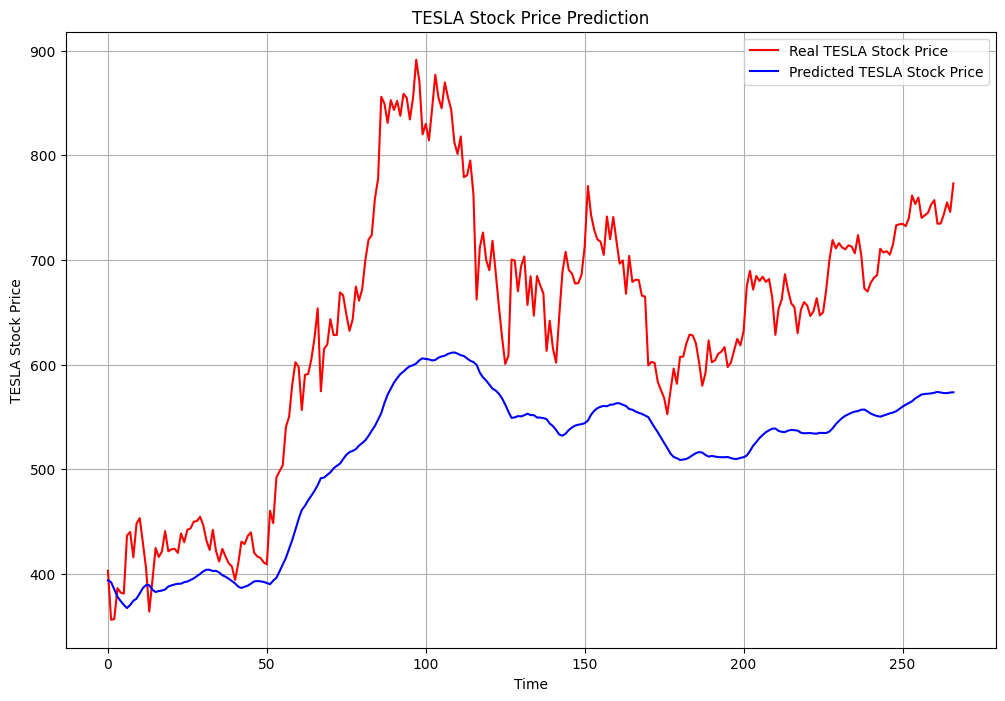

In [54]:
predicted_stock_price = eval_model(stacked_bidir, X_test, y_test)


# Visualising the results
plt.figure(figsize=(12,8))
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
#plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.grid(True)
plt.show()




## Stacked Bidirectional GRU

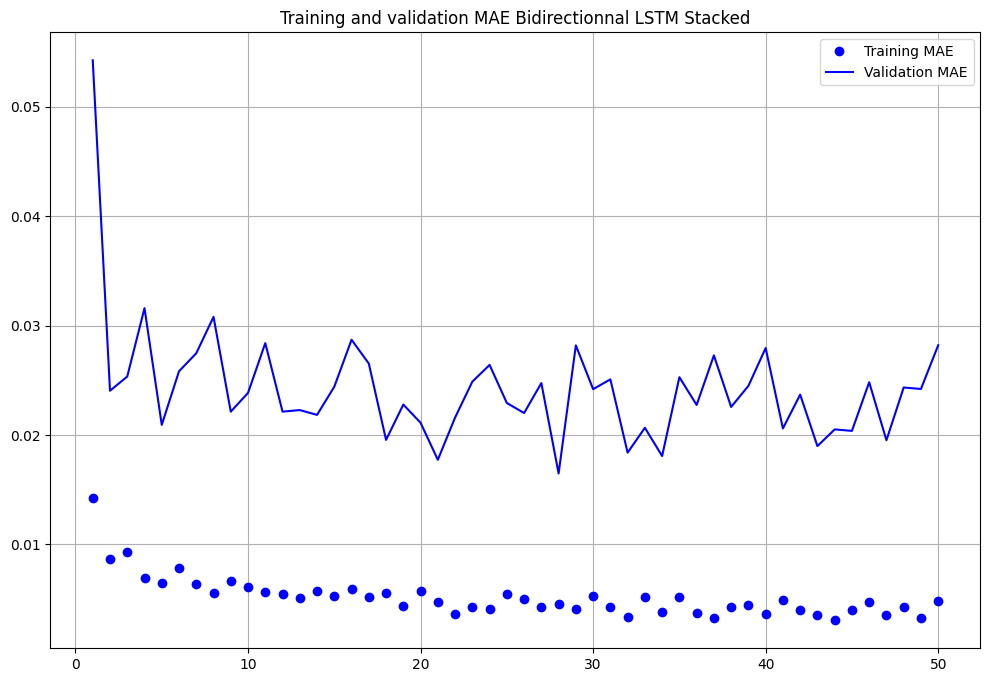

In [73]:
stacked_bidir = "stacked_bidir_gru.keras"
inputs = keras.Input(shape=(X_train.shape[1],1))
x = layers.Bidirectional(layers.GRU(50, return_sequences=True, recurrent_dropout=0.25))(inputs)
x = layers.Bidirectional(layers.GRU(50, recurrent_dropout=0.25, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(50, recurrent_dropout=0.25))(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(stacked_bidir,
                                    save_best_only=True)
]


model.compile(optimizer="NAdam", loss="mse", metrics=["mae"])
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=callbacks, verbose=0)


loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE Bidirectionnal LSTM Stacked")
plt.legend()
plt.grid(True)
plt.show()




Test MAE: 66.88


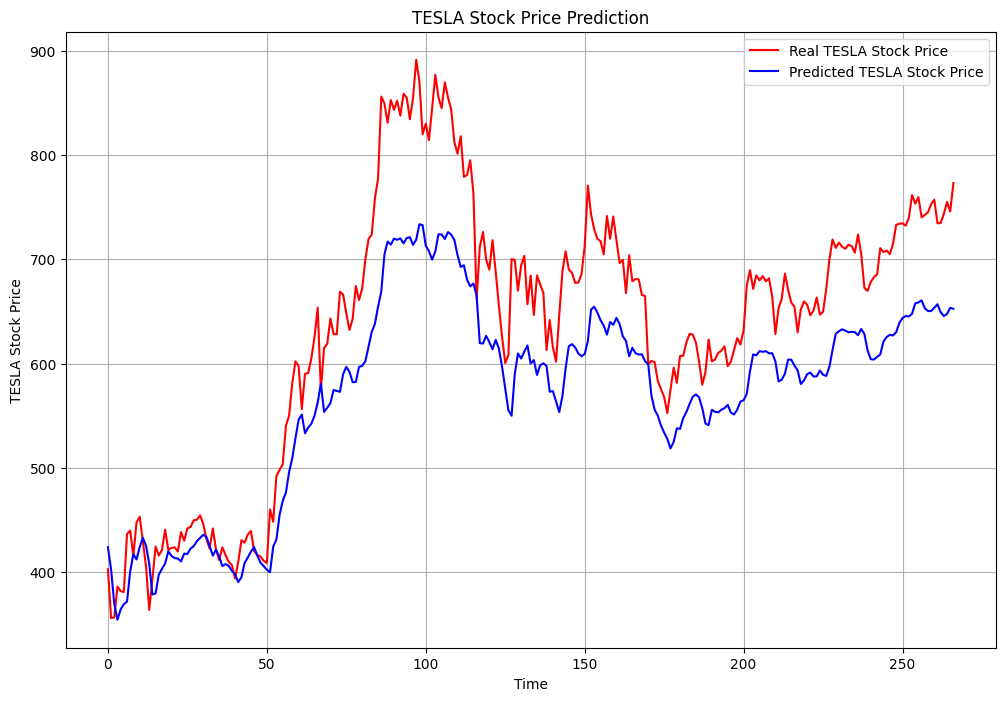

In [74]:
predicted_stock_price = eval_model(stacked_bidir, X_test, y_test)


# Visualising the results
plt.figure(figsize=(12,8))
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
#plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.grid(True)
plt.show()





## Facebook Prophet

In [ ]:
#!pip3 install "pystan<3"
#!pip3 install fbprophet

In [75]:
data = df[['Date', 'Close']]

In [76]:
data.head()

,Date,Close
0,2015-07-09,51.584000
1,2015-07-10,51.830002
2,2015-07-13,52.431999
3,2015-07-14,53.130001
4,2015-07-15,52.627998


In [77]:
data.columns = ['ds', 'y']

In [78]:
data.head()

,ds,y
0,2015-07-09,51.584000
1,2015-07-10,51.830002
2,2015-07-13,52.431999
3,2015-07-14,53.130001
4,2015-07-15,52.627998


In [79]:
from fbprophet import Prophet

In [80]:
model_prophet = Prophet(daily_seasonality = True) # the Prophet class (model)
model_prophet.fit(data) # fit the model using all data



INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


<Figure size 1200x800 with 0 Axes>

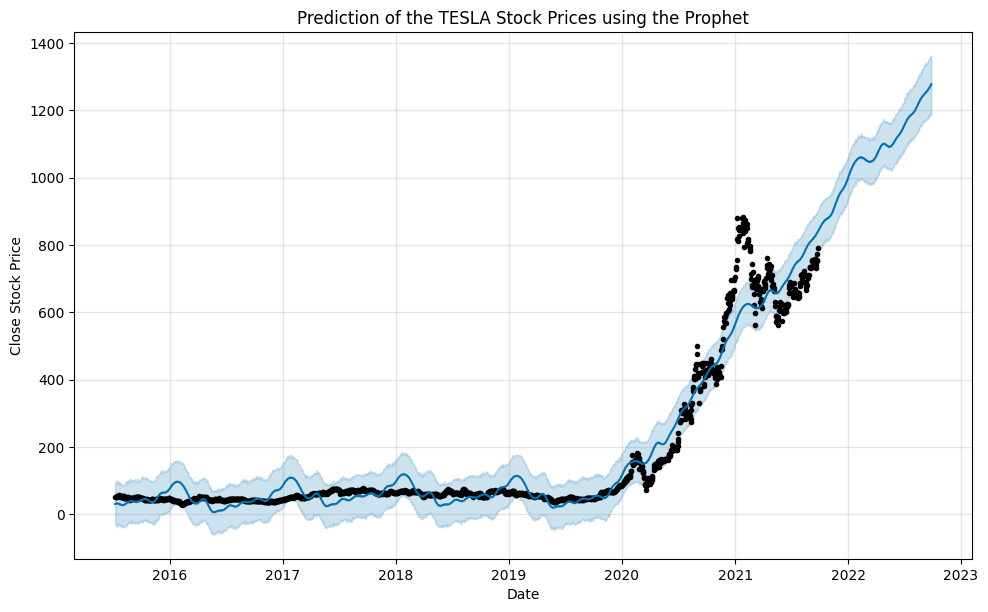

In [82]:
plt.figure(figsize=(12,8))
future = model_prophet.make_future_dataframe(periods=365) #we need to specify the number of days in future
prediction = model_prophet.predict(future)
model_prophet.plot(prediction)
plt.title("Prediction of the TESLA Stock Prices using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.grid(True)
plt.show()

In [83]:
model_prophet = Prophet(daily_seasonality = True) # the Prophet class (model)
model_prophet.fit(data.iloc[1050:,:]) # fit the model using all data



<Figure size 1200x800 with 0 Axes>

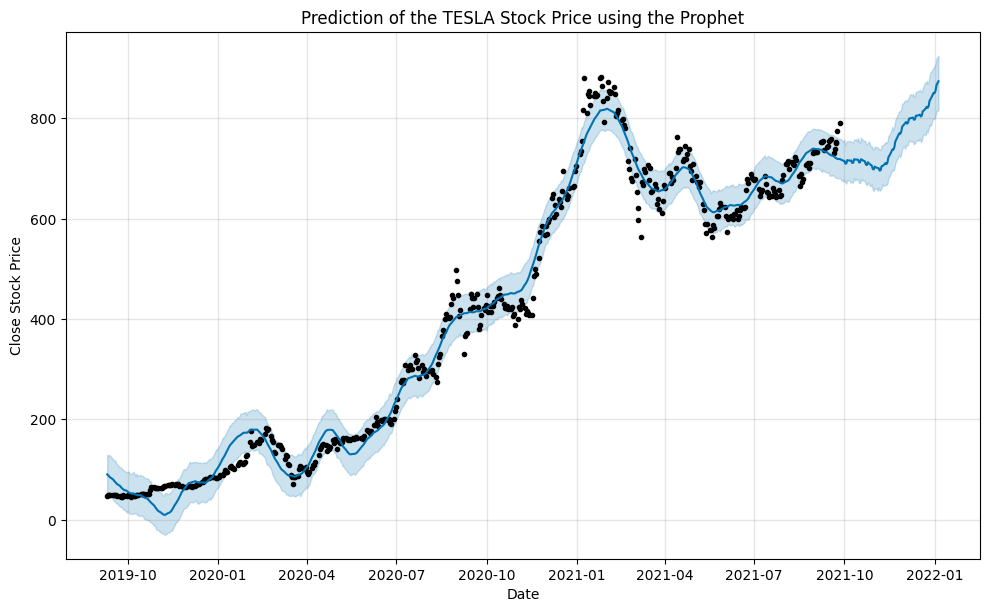

In [84]:
plt.figure(figsize=(12,8))
future = model_prophet.make_future_dataframe(periods=100) 
#we need to specify the number of days in future
prediction = model_prophet.predict(future)
model_prophet.plot(prediction)
plt.title("Prediction of the TESLA Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.grid(True)
plt.show()

## Darts

In [ ]:
#!pip3 install darts

